In [62]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data
%matplotlib inline

dash = pd.read_csv('/home/ml/datasets/DASH1440.csv',delimiter=',', parse_dates=[['Date', 'Time']])
dash.head()

,Date_Time,Open,Max,Min,Close,Volume
0,2017-05-15,86.90,93.81,84.76,92.85,651
1,2017-05-16,93.54,93.54,86.00,87.06,983
2,2017-05-17,87.06,91.14,79.73,84.20,907
3,2017-05-18,84.21,92.03,84.20,91.25,869
4,2017-05-19,92.11,102.31,86.17,97.84,1159


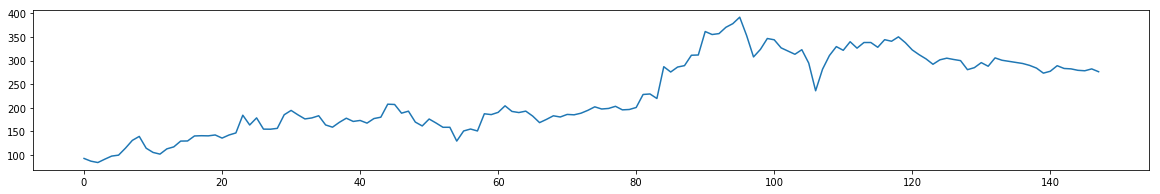

In [63]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(dash.index, dash['Close'] , label="Close")

In [64]:
dash['SMA15'] = dash['Close'].rolling(15).sum()
dash['SMA15'] = dash['SMA15'].fillna(0)
dash['Direction'] = np.sign(dash['Close'].pct_change())
dash['Direction'] = dash['Direction'].fillna(0)
print(np.unique(dash.Direction))
dash.tail()

[-1.  0.  1.]


,Date_Time,Open,Max,Min,Close,Volume,SMA15,Direction
143,2017-10-26,283.42,289.24,279.50,282.54,9323,4344.39,-1.0
144,2017-10-27,281.11,284.50,274.70,279.50,8830,4338.79,-1.0
145,2017-10-29,270.94,282.50,270.68,278.53,7647,4321.56,-1.0
146,2017-10-30,278.53,286.16,278.37,282.50,6122,4315.96,1.0
147,2017-10-31,282.52,283.49,276.32,276.50,8013,4286.66,-1.0


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier


n_train = (dash['Date_Time'].count()*0.7).astype(int)

X = dash[["Open","Max","Min","Close","Volume",'SMA15']]
y = dash['Direction']

X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:] 

pipe = Pipeline([("scaler", MinMaxScaler()),("mlp",MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10]))])

In [66]:
pipe.get_params().keys()

dict_keys(['steps', 'scaler', 'mlp', 'scaler__copy', 'scaler__feature_range', 'mlp__activation', 'mlp__alpha', 'mlp__batch_size', 'mlp__beta_1', 'mlp__beta_2', 'mlp__early_stopping', 'mlp__epsilon', 'mlp__hidden_layer_sizes', 'mlp__learning_rate', 'mlp__learning_rate_init', 'mlp__max_iter', 'mlp__momentum', 'mlp__nesterovs_momentum', 'mlp__power_t', 'mlp__random_state', 'mlp__shuffle', 'mlp__solver', 'mlp__tol', 'mlp__validation_fraction', 'mlp__verbose', 'mlp__warm_start'])

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = {'mlp__activation':['tanh', 'relu', 'logistic'],
             'mlp__alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Beste Genauigkeit nach Kreuzvalidierung: {:.2f}".format(grid.best_score_))
print("Bester Score auf den Testdaten: {:.2f}".format(grid.score(X_test, y_test)))
print("Beste Parameter: {}".format(grid.best_params_))

/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Beste Genauigkeit nach Kreuzvalidierung: 0.79
Bester Score auf den Testdaten: 0.71
Beste Parameter: {'mlp__activation': 'relu', 'mlp__alpha': 0.01}


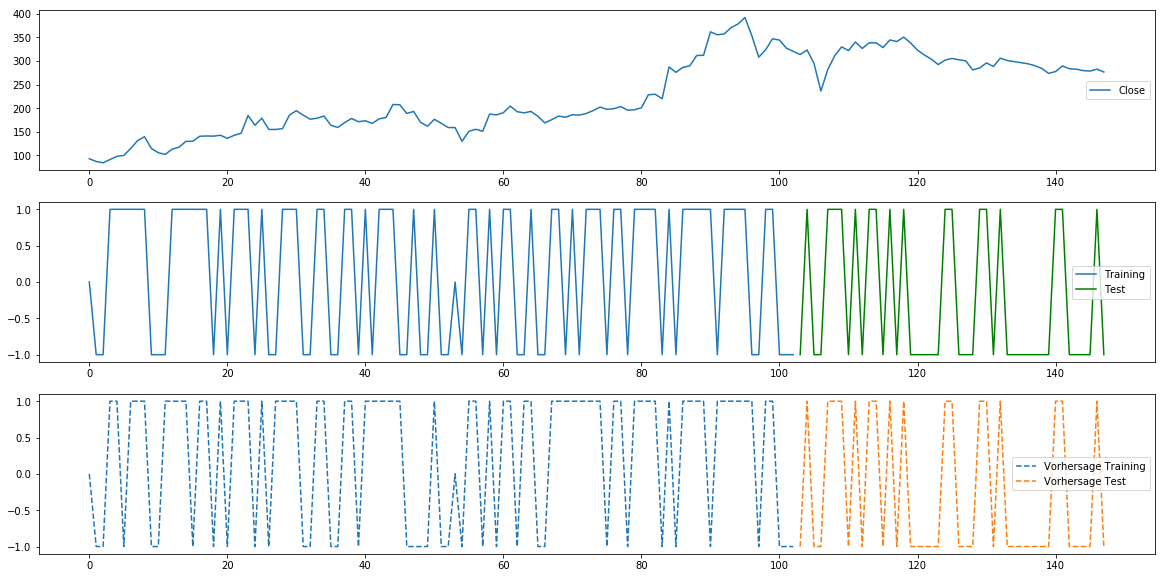

In [69]:
pipe.fit(X_test,y_test)
y_pred = pipe.predict(X_test)
pipe.fit(X_train,y_train)
y_pred_train = pipe.predict(X_train)

plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(range(0, len(y_test) + n_train), dash['Close'] , label="Close")
 
plt.legend(loc=('right'))
plt.subplot(312)
plt.plot(range(n_train), y_train, '-',label="Training")
plt.plot(range(n_train, len(y_test) + n_train), y_test, 'g-', label="Test")
plt.legend(loc=('right'))
plt.subplot(313)
plt.plot(range(n_train), y_pred_train, '--', label="Vorhersage Training")
plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Vorhersage Test")
plt.legend(loc=('right'))

In [95]:
import time
start_date = pd.Timestamp('2017-10-27')
test_vector_down = [281.11,284.50,274.70,279.50,8830,4338.79]
test_vector_up = [129.86,140.46,129.25,140.46,1169,1711.04]

In [96]:
dash.head(30)

,Date_Time,Open,Max,Min,Close,Volume,SMA15,Direction
0,2017-05-15,86.90,93.81,84.76,92.85,651,0.00,0.0
1,2017-05-16,93.54,93.54,86.00,87.06,983,0.00,-1.0
2,2017-05-17,87.06,91.14,79.73,84.20,907,0.00,-1.0
3,2017-05-18,84.21,92.03,84.20,91.25,869,0.00,1.0
4,2017-05-19,92.11,102.31,86.17,97.84,1159,0.00,1.0
5,2017-05-21,101.15,101.48,98.65,99.85,150,0.00,1.0
6,2017-05-22,99.85,144.65,93.65,114.65,1197,0.00,1.0
7,2017-05-23,111.65,137.66,111.65,131.16,989,0.00,1.0
8,2017-05-24,131.70,149.82,131.70,139.52,1605,0.00,1.0
9,2017-05-25,139.25,140.94,110.07,114.55,1978,0.00,-1.0


In [97]:
print(pipe.predict(test_vector_up))
print(pipe.predict(test_vector_down))

[ 1.]
[-1.]


/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/ml/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1)